In [1]:
import scipy.stats
import numpy as np
import joblib as jl
import sklearn.metrics
import pandas as pd

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.sandbox.stats.multicomp import get_tukey_pvalue

In [2]:
DATA = '../data/SupplTable1.h5'
supervised_methods = ['cebra_10_b', 'pivae_1_w', 'pivae_10_w', 'pivae_1_wo', 'pivae_10_wo']
supervised_methods_decoding = ['cebra_10_b', 'pivae_1_mcmc', 'pivae_10_mcmc', 'pivae_1_wo', 'pivae_10_wo']
unsupervised_methods = ['cebra_10_t', 'tsne', 'umap', 'pca']

31

  # Decoding (animal filter: 0)


  ## Supervised Methods
  
  Anova:  F_onewayResult(statistic=130.8489167329169, pvalue=3.584864370350153e-24)

  Post Hoc test:

         Multiple Comparison of Means - Tukey HSD, FWER=0.05       
    group1        group2    meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------
   cebra_10_b pivae_10_mcmc   0.0567 0.0018  0.0168 0.0965   True
   cebra_10_b   pivae_10_wo   0.1066    0.0  0.0668 0.1465   True
   cebra_10_b  pivae_1_mcmc   0.0726    0.0  0.0327 0.1125   True
   cebra_10_b    pivae_1_wo   0.2976    0.0  0.2577 0.3375   True
pivae_10_mcmc   pivae_10_wo     0.05 0.0075  0.0101 0.0898   True
pivae_10_mcmc  pivae_1_mcmc   0.0159 0.7863 -0.0239 0.0558  False
pivae_10_mcmc    pivae_1_wo    0.241    0.0  0.2011 0.2808   True
  pivae_10_wo  pivae_1_mcmc   -0.034 0.1269 -0.0739 0.0058  False
  pivae_10_wo    pivae_1_wo    0.191    0.0  0.1511 0.2308   True
 pivae_1_mcmc    pivae_1_wo    0.225  

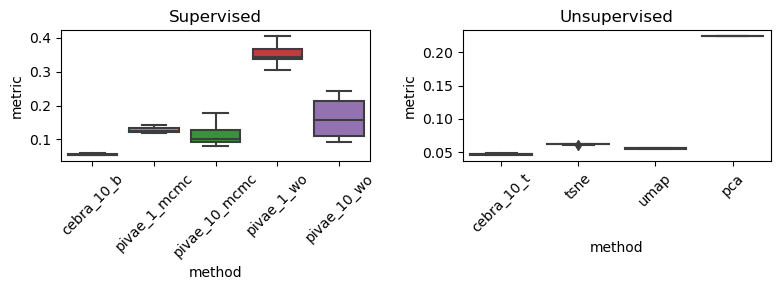

In [3]:
# for decoding
# avg over seeds
#    (# animals x # of CV runs) --> 4 x 3 --> 12

def decoding(key, animal = 0):
  data = pd.read_hdf(DATA, key = key)
  metric = "test_position_error"
  if metric + "_svm" in data.columns:
    metric =  metric + "_svm"
  data = data.pivot_table(
    metric,
    index = "animal",
    columns = "seed",
    aggfunc = lambda v : np.mean(np.array(v))
  ).agg(np.array, axis = 1)
  
  if animal is None:
    return data.agg(np.concatenate, axis = 0)
  else:
    return data.loc[animal]


for animal in [0]:
  
  def load_data(keys):
    return pd.DataFrame([
      {"method" : key, "metric" : decoding(key, animal)}
      for key in keys
    ])

  # Supervised
  data = load_data(supervised_methods_decoding)
  anova_sup = scipy.stats.f_oneway(*data.metric.values)
  data_explode = data.explode("metric")
  data_explode.metric = data_explode.metric.astype(float)
  posthoc_sup = pairwise_tukeyhsd(
    data_explode.metric.values,
    data_explode.method.values,
    alpha = 0.05
  )
  sup_data = data
  
  # Unsupervised
  data = load_data(unsupervised_methods)
  data_explode = data.explode("metric")
  print(len(data_explode))
  data_explode.metric = data_explode.metric.astype(float)
  anova = scipy.stats.f_oneway(*data.metric.values)
  posthoc = pairwise_tukeyhsd(
    data_explode.metric.values,
    data_explode.method.values,
    alpha = 0.05
  )
  unsup_data = data
  
  import seaborn as sns
  import matplotlib.pyplot as plt

  print(f"""
  # Decoding (animal filter: {animal})


  ## Supervised Methods
  
  Anova:  {anova_sup}

  Post Hoc test:

  {posthoc_sup}
  p-values: {posthoc_sup.pvalues}
  
  ## Unsupervised Methods

  Anova:  {anova}

  Post Hoc test:

  {posthoc}
  p-values: {posthoc.pvalues}
  """
  )
  
  fig, axes = plt.subplots(1,2, figsize = (8, 3))
  sns.boxplot(data = sup_data.explode("metric"), x = "method", y = "metric", ax = axes[0])  
  sns.boxplot(data = unsup_data.explode("metric"), x = "method", y = "metric", ax = axes[1])
  axes[0].set_title("Supervised")
  axes[1].set_title("Unsupervised")
  for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
  plt.tight_layout()
  plt.show()


# Subject Consistency

Anova:  F_onewayResult(statistic=25.454720289784103, pvalue=1.9171102662989993e-16)

Post Hoc test:

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
  autolfads  cebra_10_b    0.301    0.0  0.1549  0.4472   True
  autolfads  cebra_10_t    0.129 0.1192 -0.0171  0.2752  False
  autolfads  pivae_10_w   0.1049 0.3219 -0.0412  0.2511  False
  autolfads pivae_10_wo  -0.1111 0.2569 -0.2572  0.0351  False
  autolfads        tsne   0.0369 0.9876 -0.1092   0.183  False
  autolfads        umap  -0.2312 0.0002 -0.3774 -0.0851   True
 cebra_10_b  cebra_10_t   -0.172 0.0108 -0.3181 -0.0258   True
 cebra_10_b  pivae_10_w  -0.1961 0.0021 -0.3423   -0.05   True
 cebra_10_b pivae_10_wo  -0.4121    0.0 -0.5582  -0.266   True
 cebra_10_b        tsne  -0.2641    0.0 -0.4103  -0.118   True
 cebra_10_b        umap  -0.5323    0.0 -0.6784 -0.3861 

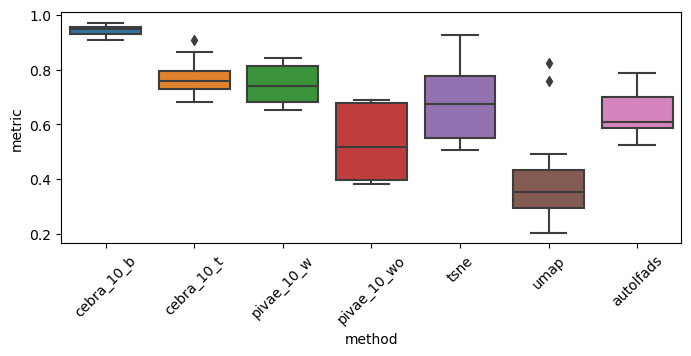

In [4]:
def subject_consistency(key):
  if key == "autolfads":
    autolfads_consistency = np.array(
    [[           0.52405768, 0.54354575, 0.5984262 ],
     [0.61116595,            0.59024053, 0.747014  ],
     [0.68505602, 0.60948229,            0.57858312],
     [0.77841349, 0.78809085, 0.65031025          ]])

    return autolfads_consistency.flatten()
  else:
    data =  pd.read_hdf(DATA, key = key).pivot_table(
      "train",
      columns = "animal",
      aggfunc = lambda v : np.mean(np.array(v))
    ).agg(np.concatenate, axis = 1).item()
    return data

def load_data(keys):
  return pd.DataFrame([
    {"method" : key, "metric" : subject_consistency(key)}
    for key in keys
  ])

methods = ['cebra_10_b', 'cebra_10_t', 'pivae_10_w', 'pivae_10_wo', 'tsne', 'umap', 'autolfads']

# Supervised
data = load_data(methods)
anova_sup = scipy.stats.f_oneway(*data.metric.values)
data_explode = data.explode("metric")
data_explode.metric = data_explode.metric.astype(float)
posthoc_sup = pairwise_tukeyhsd(
  data_explode.metric.values,
  data_explode.method.values,
  alpha = 0.05
)

print(f"""
# Subject Consistency

Anova:  {anova_sup}

Post Hoc test:

{posthoc_sup}
p-values: {posthoc_sup.pvalues}
"""
)

fig, ax = plt.subplots(1,1, figsize = (8, 3))
sns.boxplot(data = data.explode("metric"), x = "method", y = "metric", ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
plt.show()

In [5]:
rat = 0
print(f"Rat {rat}")
for key in supervised_methods_decoding:
  print(f"\t{key}\t{decoding(key, animal=rat).mean():.5f} +/- {decoding(key, animal=rat).std():.5f}")

Rat 0
	cebra_10_b	0.05459 +/- 0.00201
	pivae_1_mcmc	0.12719 +/- 0.00814
	pivae_10_mcmc	0.11124 +/- 0.02838
	pivae_1_wo	0.35220 +/- 0.02796
	pivae_10_wo	0.16123 +/- 0.05264
